# Hidden Markov Models

In this homework assignment you will train and evaluate a toy speech recognizer that can recognize 'yes' and 'no'.  As we move into the latter half of the course, note that the assignments will have less and less hand holding.  The goal is for you to become more and more independent, so that you are ready to work independently on the final project.  This assignment should be done in pairs and only one submission needs to be submitted on Gradescope for each team.  In your submission, you should create a single .zip file that contains your jupyter notebook, audio data, annotation data, and generated prediction files.

Please indicate the team member names here: ________________________

How many hours you each spent on this assignment: _________ (partner 1), __________ (partner 2)

This assignment will be broken down into 5 main sections:
1. Collect data & annotate (10 points)
2. Train model using manual annotations (20 points)
3. Perform inference on test data (20 points)
4. Infer strong labels on weakly labeled data (20 points)
5. Retrain model and evaluate on test data (20 points)

An additional 10 points will be based on how well organized, commented, and readable your code is.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
np.seterr(divide='ignore')
import matplotlib.pyplot as plt
import librosa as lb
from pathlib import Path
from scipy.stats import multivariate_normal
import glob
import warnings

### Part 1: Data Collection & Annotation

For the data collection, you will record 10 audio clips:
- Training data: 5 recordings.  Five of the audio recordings will be for training.  For these recordings, you should say a random sequence of ten yes's or no's.  For example, one recording might be 'yes no yes yes no no yes yes yes no'.  The recordings do not all have to have the same sequence of yes's and no's.  When recording your speaking, please include a variable-length silence in between each word.
- Test data: 5 recordings.  Five of the audio recordings will be for testing.  For these recordings, you should say a variable-length sequence of yes's and no's.  For example, one recording might be 'yes no' and another might be 'no yes yes no no yes no yes'.  Use a variety of different lengths in your sentences.  Again, please include silence in between each word.

All audio recordings should be done by a single person on a single device in the same environment (e.g. recorded on a cell phone in your dorm room).

Once you have recorded the audio, convert them to a format that librosa can read (e.g. wav or mp3) and put them in a folder entitled 'audio/'.  Name the files train1.mp3, train2.mp3, test1.mp3, test2.mp3, etc.

In [3]:
AUDIO_DIR = Path('audio') 
ext = '.mp3' # audio format

In [4]:
def verifyAudioData(indir, file_ext):
    # verifies that all the needed audio files are present

    # check train files
    for i in range(5):
        curfile = Path(AUDIO_DIR, f'train{i+1}').with_suffix(ext)
        assert curfile.is_file(), f'Missing training file {curfile}'

    # check test files
    for i in range(5):
        curfile = Path(AUDIO_DIR, f'test{i+1}').with_suffix(ext)
        assert curfile.is_file(), f'Missing test file {curfile}'

    print('All required audio data files are present!')
    
    return

In [5]:
verifyAudioData(AUDIO_DIR, ext)

All required audio data files are present!


Next you will create two different kinds of annotations: weak labels and strong labels.  

**Weak labels**.  Create two annotation files for the weak labels.  The file train.transcription should look like:

train1.mp3|yes no no yes no yes no no yes no\
train2.mp3|no yes yes yes no no yes no yes no\
...\
train5.mp3|yes no yes yes no no no yes no yes

The file test.transcription should look like:

test1.mp3|yes no\
test2.mp3|no yes yes no yes\
...\
test5.mp3|yes no yes no no yes no yes yes yes

**Strong labels**.  Create one annotation file for train1.mp3 (only) containing strong labels.  The file train1.labels should be in the following format:

0.00 1.37 sil\
1.37 2.60 yes\
2.60 5.20 sil\
5.20 6.30 no\
6.30 8.10 sil\
...\
12.30 13.25 yes\
13.25 15.90 sil

For annotating timestamps, I recommend that you use Audacity.  Note that we are only annotating one file with strong labels because this process is time-consuming!

In [6]:
ANNOT_DIR = Path('annot')
train_transcripts = Path(ANNOT_DIR, 'train.transcription')
test_transcripts = Path(ANNOT_DIR, 'test.transcription')
train1_labels = Path(ANNOT_DIR, 'train1.labels')

In [7]:
def verifyAnnotations():
    # verifies that all of the needed annotation files are present

    assert train_transcripts.is_file(), f'Missing transcription file {train_transcripts}'    
    assert test_transcripts.is_file(), f'Missing transcription file {test_transcripts}'    
    assert train1_labels.is_file(), f'Missing label file {train1_labels}'
    print('All required annotation files are present!')
    
    return

In [8]:
verifyAnnotations()

All required annotation files are present!


Using the above format for your label file, you should be able to visualize your labels alongside the audio in Audacity by selecting File --> Import --> Labels.  An example is shown below.  This type of visualization will be useful in evaluating how accurate your alignments and predictions are.

![Snapshot](labels_snapshot.png)

**Graded**: Please include a similar visualization of your data below.  Make sure you include your image file in your submission!

\[INCLUDE VISUALIZATION HERE\]
![Snapshot](test1image.PNG)

### Part 2: Model Training

In this part, you will train an HMM model based (only) on the label file for train1.mp3.  You must complete the implementations of the functions below.  No unit tests will be provided, though, so make sure to check your own work and verify that they are what you expect!

The function below extracts a feature called mel frequency cepstral coefficients.  Unlike chroma features, which focus on pitch (i.e. fine spectral structure), MFCCs focus on timbre (i.e. rough spectral structure) and are helpful for recognizing speech or distinguishing between different instruments.  You may use the librosa function [librosa.feature.mfcc](https://librosa.org/doc/latest/generated/librosa.feature.mfcc.html) with default arguments.

In [9]:
def computeFeatures(audiofile):
    """
    This function extracts mel frequency cepstral coefficients (MFCCs) from a given audio file.
        
    Inputs
        - audiofile: filepath to the audio recording that you want to extract MFCC features from
        
    Outputs
        - O: an F x N array containing MFCC features, where F corresponds to different features and 
             N corresponds to different audio frames
        - hop: the hop size (in seconds) between adjacent frames
    """

    ### INSERT CODE BELOW ###
    winsize=1024                    # window size   [samples]
    hop_samples=int(winsize//4)     # hop size      [samples]
    y, sr = lb.load(audiofile)      # unpack data and sample rate from audiofile
    hop_seconds = hop_samples / sr  # hop size      [seconds]
    O = lb.feature.mfcc(y=y, win_length = winsize, hop_length = hop_samples ,sr=sr) # compute mfcc features
    return (O, hop_seconds)         # return mfcc features and hop size [seconds]

The function below constructs a mapping between the states and their numeric identifiers.  For ease of grading, please use the following mapping:
- sil -> 0
- Y -> 1
- EH -> 2
- S -> 3
- N -> 4
- OH -> 5

In [10]:
def getStateMapping():
    """
    Returns a mapping between the string and numeric representations of the six different states.
    
    Outputs
      - states: a list that contains the states (in order).  This allows you to map from the numeric identifier
        to the string representation (e.g. states[3])
      - stateStr2id: a dict that maps from the state string representation to its numeric identifier (e.g. stateStr2id['EH'])
    """
    ### INSERT CODE BELOW ###
    #raise NotImplementedError
    states=["sil","Y","EH","S","N","OH"]
    stateStr2id ={
        "sil":0,
        "Y":1,
        "EH":2,
        "S":3,
        "N":4,
        "OH":5     
    }
    
    return (states, stateStr2id)

The function below converts a .labels file into a sequence of states per frame.  You may assume that states in a word have equal duration (e.g. if the word 'yes' lasts 1.2 seconds, you can assume that 'Y', 'EH', and 'S' each have duration 0.4 sec).

In [11]:
def getStatesFromLabelFile(labelfile, hopsize, str2id):
    """
    Reads in a label file and returns a sequence of states for each audio frame.  For any given word, it assumes
    that the constituent states all have equal duration.  For example, if the word 'yes' lasts 1.2 seconds, the constituent
    states 'Y', 'EH', and 'S' are assumed to each have duration 0.4 seconds.
    
    Inputs
      - labelfile: filepath to the .labels or .forcealign file 
      - hopsize: the hop size in seconds between adjacent audio frames
      - str2id: dict that maps from the state's string representation to its numeric representation

    Outputs
      - S: list containing the sequence of numeric states for each audio frame
    """
    ### INSERT CODE BELOW ###
    f = open(labelfile)
    lines = f.readlines()
    
    lastLine = lines[-1].split('\t') # extract the end time of the last label to determine the length of S
    endtime = float(lastLine[1])

    S = np.zeros(int(endtime//hopsize))

    states = ["sil", "Y", "EH", "S", "N", "OH"]

    for i in range(len(lines)):
        line = lines[i].split('\t')   # split the label into [start time, end time, label identifier]
        t1 = float(line[0])            # extract start time (convert from string to float)
        t2 = float(line[1])            # extract end time
        dur = t2 - t1                   # compute duration of label 
        ind = np.zeros(4)
        label = line[2]
        

        if 'sil' in label:           # check if 'sil' is in the label rather than checking equality to deal with inconsistent newline characters
            for i in range(2):  # generate beginning and end indices bc only one silent state
                ind[i] = int((t1 + i*dur) // hopsize)
            S[int(ind[0]): int(ind[1])] = str2id[states[0]]

        elif 'yes' in label:
            for i in range(4):  # generate equally spaced indices to separate 3 'yes' states
                ind[i] = int((t1 + i/3*dur) // hopsize)
            for i in range(3):  # assign states to S matrix
                S[int(ind[i]): int(ind[i+1])] = str2id[states[1+i]]

        elif 'no' in label:
            for i in range(3):  # generate equally spaced indices to separate 2 'no' states
                ind[i] = int((t1 + i/2*dur) // hopsize)
            for i in range(2):  # assign states to S matrix
                S[int(ind[i]): int(ind[i+1])] = str2id[states[i+4]] 
    
    return S

In [12]:
file= "annot/train1.labels"
hop = 0.1
states, str2id = getStateMapping()
S = getStatesFromLabelFile(labelfile = file, hopsize = hop, str2id = str2id)

This is a good place to verify that your functions are producing correct outputs:

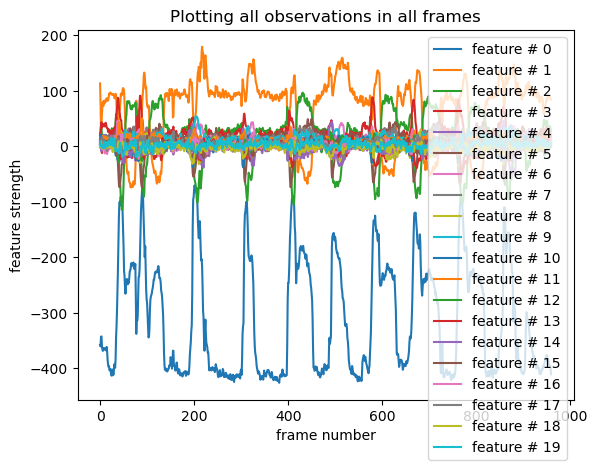

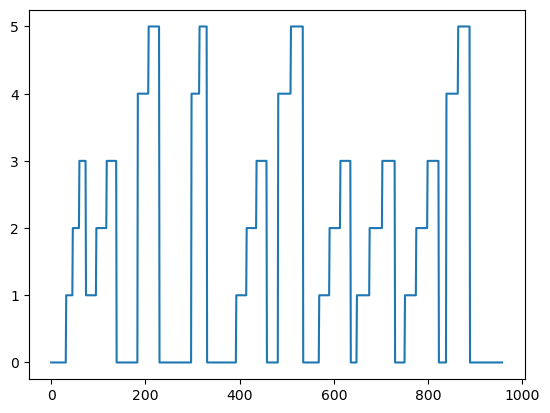

In [15]:
O, hop = computeFeatures(Path(AUDIO_DIR, 'train1.mp3'))
states, stateStr2id = getStateMapping()
S = getStatesFromLabelFile(train1_labels, hop, stateStr2id)

#plotting to see
plt.figure()
plt.title("Plotting all observations in all frames")
plt.ylabel("feature strength")
plt.xlabel("frame number")
c=0
for feat in O:
    plt.plot(feat,label="feature # "+str(c))
    c=c+1
plt.legend()
plt.figure()
plt.plot(S)


The function below trains an HMM given a list of observations (i.e. MFCC feature matrices) and corresponding states.  A few helpful tips:
- In this part of the assignment, you will only train the model on the train1.mp3 example, but your function below should be able to handle multiple training examples so that you can reuse this function in part 5.
- You may assume that recordings always begin in the silent state.
- You should assume that the emission probability model is a multivariate Gaussian model.
- You should decompose this function and define other sub-functions as needed to keep your code neat and organized.

In [16]:
def trainHMM(O_list, S_list, states):
    """
    Trains an HMM given a list of observations and corresponding states.  The HMM assumes a multivariate Gaussian
    emission probability model.

    Inputs
      - O_list: a list of matrices, where each matrix contains the MFCC coefficients for a single training recording
      - S_list: a list of arrays, where each array specifies the states in each audio frame for a single training recording
      - states: a list specifying the states in their string representation

    Outputs
      - A: the state transition probability matrix
      - pi: the distribution of the initial state
      - means: a matrix where each row specifies the mean of the distribution for a single state
      - covars: a 3D tensor where the first index specifies a state, and the remaining two indices specify the covariance 
        matrix for the state's distribution
    """
    ### INSERT CODE BELOW ###

    """
    Note:
    Phases of function:
      1. determine A matrix by going through the entire list of states. Index aij will be # of times there is a state transition from i to j / total number of transitions from i to another state
      2. Determine initial pi by perhaps averaging probabilities over all states, or simply choosing an initial probability
      3. Generate list of means: where mu_i corresponds to the average of all observations for state i
      4. From the means, generate covariance matrices for all i states

    """

    state_names,mapping=getStateMapping()
    num_records=len(O_list) #number of records
    observation_size=np.shape(O_list)[1]

    num_states=len(states)
    A_sum = np.zeros((num_states,num_states)) 
    A = np.zeros((num_states,num_states)) 
    observations_sum = np.zeros((num_states,observation_size)) #summed observation for each state
    total_state_count_list=np.zeros(num_states) #total number of times a state appears for all recordings
    means=np.zeros((num_states,observation_size)) #mean of observations across all recordings
    covars=np.zeros((num_states,observation_size,observation_size)) #covariance matrices for all recordings

    #looping through all recordings 
    for i in range(num_records):
      S_record=S_list[i]
      O_record=O_list[i]
      A=A[i]+countTransitions(S_record,states) #Sum up all the precursor A matrices to compute values for all recordings
      state_count_list=countNumStates(S_record, states) #list containing the number of time a state appears for this file

      total_state_count_list=total_state_count_list+state_count_list# add this to the count of number of times state appears for all files
      observations_sum=observations_sum+countObservations(O_record,S_record,states) #sum up all the observations to compute the average later



    #computing the A matrix for all recordings
    transitions_sum = np.einsum("ij->i",A) #each element is the total number of transitions from each state index i. This sums the rows.
    for i in range(len(transitions_sum)):
      A[i,:]=A[i,:]/transitions_sum[i] #now divide by the total number of transitions

    #computing average observation and covariances
    for i in range(num_states):
      means[i,:]=observations_sum[i,:]/total_state_count_list[i]  #average observation
      
      
      #TODO see if this can be optimized/vectorized 
      dif_vec = np.array([O_list[k,:,j]-means[i,:] for k in range(num_records) for j in range(np.shape(O_list[k])[1])]).T #vector across records and time
      
      covar_sum=np.zeros((observation_size,observation_size))
      for k in range(np.shape(dif_vec)[1]):
        outer_prod=np.outer(dif_vec[:,k],dif_vec[:,k])
        covar_sum=covar_sum+outer_prod

        
      covars[i,:,:]=(1/(total_state_count_list[i]-1))*covar_sum


    pi=total_state_count_list/np.sum(total_state_count_list)

    #pi=0

    #raise NotImplementedError
    return (A, pi, means, covars)

def findPi(S_list, states):
  """

  """

def countTransitions(S_record,states):
  num_states=len(states)
  num_transitions_mat=np.zeros((num_states,num_states)) 
  for i in range(len(S_record)-1):
    current_state=int(S_record[i]) #string of current state
    next_state=int(S_record[i+1] )#string of next state

    num_transitions_mat[current_state,next_state]=num_transitions_mat[current_state,next_state]+1 

  
  return num_transitions_mat






def countNumStates(S_list,states):
  state_count =np.zeros(len(states)) #keeps count of how many times a state appears
  for i in range(len(S_list)):
    current_state=int(S_list[i] )
    state_count[current_state]=state_count[current_state]+1
  return state_count


def countObservations(O_record,S_record,states):
  """
  """
  #TODO O RECORDSAND S RECORDS ARE NOT THE SAME LENGTH, NEED TO FIX
  sum_observations = np.zeros((len(states),np.shape(O_record)[0])) #summed observation for each state
  print("O_record:countObervsations",np.shape(O_record))
  print("S_record:countObervsations",np.shape(S_record))
  for i in range(len(S_record)):
    current_state=int(S_record[i])#current state
    current_observation=O_record[:,i]
    sum_observations[current_state,:]=sum_observations[current_state,:]+current_observation #add current observation to running count
  return sum_observations




"""
def generateCovariances(O_list,states,means,state_count):
  state_names,stateStr2id=getStateMapping(states)
  obs_size=np.shape(O_list)[1]
  #state_count =countNumStates(S_list,states) #keeps count of how many times a state appears
  variances = np.zeros((len(states),obs_size,obs_size))#variances for each state

  

  for i in range(len(states)):
    dif_vector = O_list-means[i] #subtract the average observation of state i from all of the observations over time
    variances[i,:,:]=(1/(state_count[i]-1))*np.sum(dif_vector@dif_vector.T)

  return variances
"""



'\ndef generateCovariances(O_list,states,means,state_count):\n  state_names,stateStr2id=getStateMapping(states)\n  obs_size=np.shape(O_list)[1]\n  #state_count =countNumStates(S_list,states) #keeps count of how many times a state appears\n  variances = np.zeros((len(states),obs_size,obs_size))#variances for each state\n\n  \n\n  for i in range(len(states)):\n    dif_vector = O_list-means[i] #subtract the average observation of state i from all of the observations over time\n    variances[i,:,:]=(1/(state_count[i]-1))*np.sum(dif_vector@dif_vector.T)\n\n  return variances\n'

Use the functions defined above to train an HMM model on the train1.labels file (only).  For grading purposes, please print out the following variables (and make sure your submitted notebook is showing the values): 
- the state transition probability matrix A
- the means for all six states
- the covariance matrix for 'sil'

In [62]:
### INSERT AS MANY CELLS AS NEEDED BELOW ###
## RAFAEL 
audiofile = Path(AUDIO_DIR, "train1.mp3")
labelfile = Path(ANNOT_DIR, "train1.labels")

train1_obs, hop = computeFeatures(audiofile = audiofile) # compute observations and hop size from audio file

#test to see what happens if i set O[feature 0 ]to 0
train1_obs[0,:]=train1_obs[0,:]+300


states, stateStr2id = getStateMapping() # retrieve list of possible states and mapping between string and integer state representation

train1_states = getStatesFromLabelFile(labelfile = labelfile, hopsize = hop, str2id = stateStr2id) # generate state list for audio file from strong labels

O_list=np.array([train1_obs])
S_list=np.array([train1_states])

A, pi, means, covars = trainHMM(O_list, S_list, states)


O_record:countObervsations (20, 960)
S_record:countObervsations (958,)


[-100.06877057   90.72818102   22.76104346   22.79352016   12.5259131
   16.38384779    9.15470873   10.78352904    5.56201792   10.79966335
    4.61305193    6.39504215    1.67721755    2.90329359   -1.65897524
    2.36835092    0.67374001    3.56804727   -1.29386506    3.87393941]
[-57.7912    113.13663    13.636952   20.3457     10.8145275   9.55143
   2.5668592  14.350315    4.454041    9.549       4.38103     7.475975
  -1.8856592   6.028185    4.3644123   1.9656672   3.0689733   1.9225539
  -1.6029589   8.375549 ]


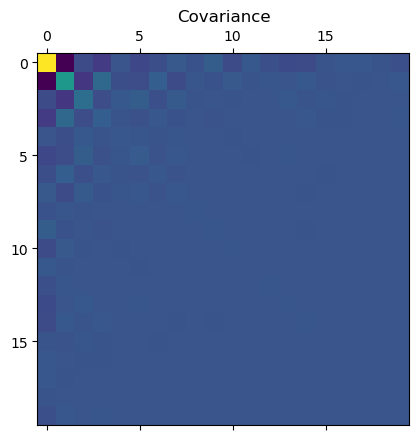

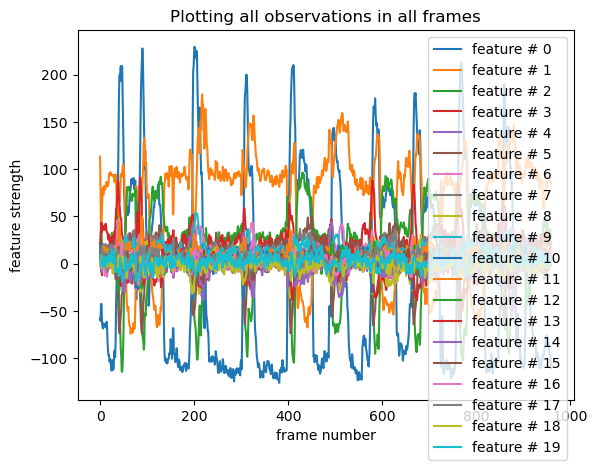

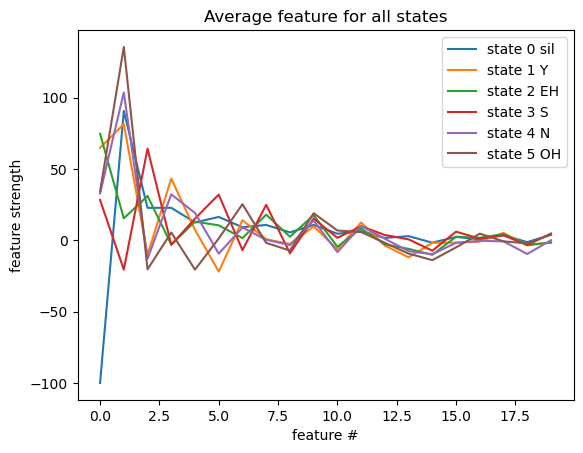

In [63]:

print(means[0]) #check to see if the average silent frame looks similar to a known silent frame
print(O_list[0][:,0])



plt.matshow(covars[2])
plt.title("Covariance")
plt.figure()
plt.title("Plotting all observations in all frames")
plt.ylabel("feature strength")
plt.xlabel("frame number")
c=0
for feat in O_list[0]:
    plt.plot(feat,label="feature # "+str(c))
    c=c+1
plt.legend()

plt.figure()
plt.title("Average feature for all states")
plt.xlabel("feature #")
plt.ylabel("feature strength")
c=0
for state in means:
    plt.plot(state,label="state "+str(c)+" "+states[c])
    c=c+1
plt.legend()



**Graded**: Print out A below

In [64]:
A

array([[0.97650131, 0.01305483, 0.        , 0.        , 0.01044386,
        0.        ],
       [0.        , 0.95419847, 0.04580153, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.95419847, 0.04580153, 0.        ,
        0.        ],
       [0.03846154, 0.00769231, 0.        , 0.95384615, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.95652174,
        0.04347826],
       [0.04444444, 0.        , 0.        , 0.        , 0.        ,
        0.95555556]])

**Graded**: Print out the state distribution means below

In [65]:
means

array([[-1.00068771e+02,  9.07281810e+01,  2.27610435e+01,
         2.27935202e+01,  1.25259131e+01,  1.63838478e+01,
         9.15470873e+00,  1.07835290e+01,  5.56201792e+00,
         1.07996634e+01,  4.61305193e+00,  6.39504215e+00,
         1.67721755e+00,  2.90329359e+00, -1.65897524e+00,
         2.36835092e+00,  6.73740011e-01,  3.56804727e+00,
        -1.29386506e+00,  3.87393941e+00],
       [ 6.48455425e+01,  8.15141005e+01, -1.01412327e+01,
         4.33034525e+01,  7.34262728e+00, -2.19423592e+01,
         1.40825508e+01,  6.90334773e-01, -2.57736562e+00,
         9.72487043e+00, -6.22558625e+00,  1.25156842e+01,
        -3.68433266e+00, -1.19449810e+01, -1.80965153e+00,
        -1.61406514e+00, -9.54488081e-01,  5.18779683e+00,
        -3.60673433e+00, -1.42947933e+00],
       [ 7.47416791e+01,  1.53658334e+01,  3.10831814e+01,
        -2.98850778e+00,  1.31041979e+01,  1.05136127e+01,
         1.51622955e+00,  1.80121328e+01,  2.50224520e+00,
         1.76327167e+01, -4.4

**Graded**: Print out the covariance matrix for 'sil' below

In [66]:
covars[0]

array([[ 4.57296827e+04, -8.88581576e+03, -6.15776050e+03,
        -1.68660452e+03, -1.31382713e+03, -5.00723317e+03,
        -1.39453923e+02, -9.29127679e+02, -2.40085028e+03,
         1.47139959e+03, -1.60395053e+03,  1.09092863e+03,
        -8.15292320e+02, -2.87221060e+03, -1.65019840e+03,
        -6.12088303e+02,  3.52994422e+02,  3.93704814e+00,
        -6.12410223e+02, -7.02761919e+02],
       [-8.88581576e+03,  9.87378491e+03, -4.26860597e+03,
         1.79793317e+03, -7.20843297e+02, -9.34608907e+02,
         1.21242442e+03, -1.07770207e+03,  9.56098443e+02,
        -3.16495157e+02,  4.60356088e+02, -4.11268628e+02,
         1.84699552e+01, -6.56492019e+01,  3.71582271e+02,
        -3.21418058e+02,  2.54020483e+01, -3.54378665e+01,
         1.51828097e+02,  3.32735059e+01],
       [-6.15776050e+03, -4.26860597e+03,  5.44483660e+03,
        -9.06930809e+02,  7.70198310e+02,  2.06110487e+03,
        -7.98435286e+02,  9.87046663e+02, -1.89437128e+02,
        -2.47619527e+02, -4.0

### Part 3: Inference

In this part, we will use our trained model from part 2 to estimate the state sequence on test recordings.  You must complete the implementations of the functions below.  Again, no unit tests will be provided, so make sure to check your own work!

The function below calculates a pairwise similarity matrix, assuming a Gaussian emission probability model.  You may use the scipy implementation of [multivariate_normal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html) in your implementation.

In [67]:
# RAFAEL 
def calcSimilarity_multivariateGaussian(O, means, covars):
    """
    Calculates the matrix of likelihoods for a sequence of observations and a set of multivariate Gaussian models.

    Inputs
      - O: an D x N observation matrix, where D is the dimensionality of the feature representation and N is the number
        of observations
      - means: an M x D matrix specifying the distribution means, where M is the number of multivariate Gaussian models 
      - covars: an M x D x D array specifying the distribution covariance matrices, where the first index specifies the model
        and the remaining two indices specify the model's covariance matrix

    Outputs
      - prob: a M x N matrix specifying model likelihoods, where M corresponds to the different models and where N corresponds
        to the different observations
    """
    ### INSERT CODE BELOW ###
    
    M = means.shape[0]  # unpack required matrix dimensions
    N = O.shape[1]      

    prob = np.zeros((M,N))

    for row in range(M):  # loop through models
        model_E = means[row, :]   # unpack current model mean
        model_Sig = covars[row, :, :]   # unpack current model covariance
        gauss_dist = multivariate_normal(mean = model_E, cov = model_Sig)   # generate gaussian distributiuon for current model
        for col in range(N): # loop through audio frames
            prob[row, col] = gauss_dist.pdf(x=O[:,col])
            



        """
        model_E = means[row, :]   # unpack current model mean
        model_Sig = covars[row, :, :]   # unpack current model covariance
        dist = multivariate_normal(mean = model_E, cov = model_Sig)   # generate gaussian for current model
        print(dist.pdf(O).shape)    
        prob[row, :] = dist.pdf(O)  # evaluate current model distribution at the observations 
        """
    return prob

The function below implements the Viterbi algorithm from scratch.  Since there are lots of implementations of Viterbi online, you should not consult any direct implementations.  If you are unable to complete this part on your own, you may consult an online implementation for a grade deduction.  If you do so, please cite the resource and describe the extent of the assistance so that points may be deducted appropriately.

**Graded**: Please cite any resources you consulted in implementing the function below, and the extent of the assistance: 

\<PUT RESPONSE HERE\>

In [68]:
# RAFAEL
def viterbi(prob, A, pi):
    """
    Inputs
      - prob: a M x N matrix specifying model likelihoods, where M is the number of models and N is the number of observations
      - A: an M x M transition probability matrix
      - pi: a length M array specifying the initial state probability distribution
        
    Outputs
      - S_est: the estimated sequence of (numeric) states
    """
    ### INSERT CODE BELOW ###

    M,N = prob.shape

    pi = pi.reshape(M,) # make sure pi is a column vector
    
    #### CONSTRUCT D AND B MATRICES

    D = np.zeros((M, N))  # Allocate cumulative path score matrix D
    B = np.zeros((M, N))  # Allocate backrace matrix B

    D[:,0] = np.log(pi) + np.log(prob[:,0]) # Initialize first column of D
    
    for f in range(1,N): # iterate over all frames (f)
        for s in range(M): # iterate over all possible states (s) for each frame
            transitions = A[:,s] # column vector of transitions from all states -> state s
            p = prob[s,f] # probability of state s occuring in frame f
            scores = D[:,f-1] + np.log(transitions) + np.log(p) # scores = scores from previous frame + transition score + probability
            D[s, f] = np.max(scores)    # assign max of possible scores to cumulative score matrix entry
            B[s, f] = np.argmax(scores) # assign backpointer to be index of max possible score

    #### EXTRACT ESTIMATED PATH THROUGH D
    S_est = np.zeros(N)
    S_est[0] = np.argmax(D[:,-1]) # construct estimated state sequence in reverse order, will flip at end

    for i in range(1,N):
        S_est[i] = B[int(S_est[i-1]),N-i]

    return np.flip(S_est) # flip estimated state sequence to forward orientation and return

In [69]:
## Testing Viterbi implementation
M = 4
N = 5
# construct simple prob, pi, and A matrices
test_prob = np.zeros((M,N))
test_prob[0,0] = 1
test_prob[1,1] = 1
test_prob[0,2] = 1
test_prob[2,3] = 1
test_prob[3,4] = 1
test_pi = np.array([0.1, 0.1, 0.2, 0.3])
test_A = np.zeros((M, M)) + 0.25
print(test_prob)

viterbi(test_prob, test_A, test_pi)

[[1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


array([0., 1., 0., 2., 3.])

Using the two functions above, estimate the state sequence for each test recording and generate the corresponding .labels file (it can have a different extension but should have the same format so as to be readable by Audacity).  Include a visualization of your estimated states alongside the audio in Audacity (as shown above).  You may use as many code cells as needed, and be sure to decompose your code appropriately!

In [70]:
### INSERT AS MANY CELLS AS NEEDED BELOW ###

In [71]:
### FIRST, CREATE FUNCTION FOR ESTIMATING THE STATE SEQUENCE OF A RECORDING

# this really just strings together some of the functions from above 
def estimateStateSequence(test_file, means, covars, prob, A, pi):
    obs, hop = computeFeatures(test_file)
    prob = calcSimilarity_multivariateGaussian(O = obs, means = means, covars = covars)
    S_est = viterbi(prob = prob, A = A, pi = pi)
    return S_est


In [72]:
"""
    These next lines extend the existing covars to the correct dimensionality and store it in TEMP. 
    TODO: switch back to using normal covars once trainHMM is fixed
"""
TEMP = np.zeros((6,20,20))
for i in range(6):
    TEMP[i,:,:] = covars[i,:,:]

In [73]:
### ESTIMATE STATE SEQUENCE FOR EACH TEST RECORDING
test_files = glob.glob("audio/test*.mp3") # retreive relevant files
S_est_list = []

for i in range(len(test_files)):    # iterate through files 
    S_est = estimateStateSequence(test_files[i], means=means, covars=TEMP, prob=prob, A=A, pi=pi)
    S_est_list.append(S_est)    # append state sequence fo list (can't use np array bc different sequence lengths)

NameError: name 'prob' is not defined

In [74]:
### DEFINE FUNCTION TO IDENTIFY STATE TRANSITIONS CORRESPONDING TO LABEL CHANGES
def isLabelChange(state_pair):
    """
        inputs: 
            state_pair = [s_i-1, s_i] (estimated states in audio frames i-1 and i of current test file)
        returns:
            1, if the s_i-1->s_i transition constitutes a label change
            (   acceptable label-change transitions: 
                S->N, S->sil
                OH->Y, OH->sil
                sil->N, sil->Y  )
    """
    s0, s1 = (int(state_pair[0]), int(state_pair[1]))
    if states[s0] == 'S':
        return (states[s1] == 'N' or states[s1] == 'sil')
    elif states[s0] == 'OH':
        return (states[s1] == 'Y' or states[s1] == 'sil')
    elif states[s0] == 'sil':
        return (states[s1] == 'N' or states[s1] == 'Y')
    else:
        return 0

In [75]:
### COMPILE LIST FOR LABEL-CHANGE INDICES OF ALL THE TEST FILES

lc_inds = [] # initialize list to store label change index arrays (each entry is an array of indices for a different test file)
for i in range(len(S_est_list)): # iterate through S_est_list entries
    cur_inds = [0] # initialize list to store label change indices for current test file (first index = 0)
    for index in range(1,len(S_est_list[i])):   # iterate through current state sequence
        if isLabelChange(S_est_list[i][index-1:index+1]): # if there is a change in estimated state, log index in current index list
            cur_inds.append(index)  
    cur_inds.append(index) # add index for end of record
    lc_inds.append(cur_inds)  # record temp index list (for current sequence) in compiled index list

In [76]:
### COMPILE LABEL-CHANGE TIMESTAMP LIST FROM THE LABEL-CHANGE INDEX LIST (same format)

lc_ts = [] # initialize list to store label-change timestamp arrays
for i in range(len(lc_inds)):
    cur_ts = np.array(lc_inds[i]) * hop # convert indices to timestamps by multiplying by hop length [seconds]
    lc_ts.append(cur_ts)

In [77]:
### GENERATE LABEL INDICATOR SEQUENCES (yes, no, sil, ...)

# first, collapse state sequence (eliminate adjacent duplicates)

S_col_list = [] # initialize collapsed state estimate list
for file_num in range(len(S_est_list)):
    cur_S_col = [S_est_list[file_num][0]]
    for index in range(len(S_est_list[file_num])):
        if S_est_list[file_num][index] != S_est_list[file_num][index-1]:
            cur_S_col.append(S_est_list[file_num][index])
    S_col_list.append(cur_S_col)

# now, generate label indicator sequence from collapsed state sequence

li_list = [] # initialize label indicator list (for all test files)
for i in range(len(S_col_list)):
    cur_li = []
    counter = 0
    while (counter < len(S_col_list[i])):
        if S_col_list[i][counter] == 0:
            cur_li.append('sil')
            counter = counter+1
        elif S_col_list[i][counter:counter+2] == [4,5]:
            cur_li.append('no') 
            counter = counter+2
        elif S_col_list[i][counter:counter+3] == [1,2,3]:
            cur_li.append('yes')
            counter = counter+3
        else: 
            counter = counter+1
            warnings.warn(message = "Non-label state sequence encountered")
        
    li_list.append(cur_li)

In [78]:
### DEFINE FUNCTIONS FOR WRITING TO .LABELS FILE

def writeLabel(label_indicator, label_timestep, file):
    start, stop = (label_timestep[0], label_timestep[1])
    line = "%f\t%f\t%s\n" % (start, stop, label_indicator)
    file.write(line)

def writeLabelFile(label_indicators, label_timesteps, file_name):
    f = open(file_name, 'w')
    for i in range(len(label_indicators)):
        writeLabel(label_indicators[i], label_timesteps[i:i+2], f)
    f.close()

def generateLabelFileNames(prefix, num_trials):
    fnames = []
    for i in range(num_trials):
        fname = Path(ANNOT_DIR, '%s%d.labels'%(prefix, i+1))
        fnames.append(fname)
    return fnames

In [79]:
### WRITE LABELS FILES FOR TEST AUDIO FILES

file_names = generateLabelFileNames("test", 5)
for i in range(len(li_list)):
    writeLabelFile(li_list[i], lc_ts[i], file_names[i])

Comment on what you observe in your estimated state sequence, and propose some ideas on how you might improve the system.

**Graded**: 

\<INSERT VISUALIZATION & RESPONSE HERE\>

### Part 4: Forced Alignment

In this part, you will perform forced alignment to determine the correspondence between the states in a given word-level transcription and the corresponding audio recording.  Your goal is to implement the function below, and then use it to determine the state-level alignment for train1.mp3.  Make sure to decompose your function appropriately!

In [80]:
def forcedAlignment(audiofile, word_transcript, model, stateStr2id):
  """
  Performs forced alignment between a given word-level transcription and the corresponding audio recording.
  Inputs
    - audiofile: filepath to the audio recording
    - word_transcript: a string indicating the word-level transcription.  The transcription should only
      contain 'yes' and 'no'; the function will raise an error if it contains anything other than these two words
    - model: tuple of (A, pi, means, covars) specifying the trained HMM
    - stateStr2id: a dict that maps from the state string representation to its numeric identifier (e.g. stateStr2id['EH'])
  Output
    - alignment: an array specifying the coordinates of the forced alignment
  """
  ### INSERT CODE BELOW ###
  A,pi,means,covars=model
  features,hopsecs=computeFeatures(audiofile)
  feat_num, frames=features.shape
  #print("word_transcript",word_transcript)
  string_array=word_transcript.split(" ")
  str_array2state,state_str_arr=expandWords(string_array)
  state_arr_len=len(state_str_arr)
  transition_indices=getTransitionIndices(state_str_arr,stateStr2id) #each 
  lam=1 #lambda param
  #print("state_str_arr",state_str_arr)
  similarity_mat=calcSimilarity_multivariateGaussian(features, means, covars)# provides conditional probabilities for observations and states
  B,D=computeCostPath(features,str_array2state,state_str_arr,model,transition_indices)
  path=backtrace(B,state_str_arr)
  print("path",path)
  return B,D
  
           
def computeCostPath(features,str_array2state,state_str_arr,model,transition_indices):
  A,pi,means,covars=model
  num_feats, frames=features.shape
  lam=1 #lambda param
  state_arr_len=len(state_str_arr)
  print(str_array2state)
  D=-np.inf*np.ones((state_arr_len,frames))
  B=np.zeros((state_arr_len,frames))
  similarity_mat=calcSimilarity_multivariateGaussian(features, means, covars)# provides conditional probabilities for observations and states
  #initialize first column
  
  for i in range(state_arr_len):
    p_map=str_array2state[i] #unwrapped state index wrapped back to state space
    conditional_p=similarity_mat[p_map,0] #conditional probability for state given current state wrapped back state
    current_t_idx=transition_indices[i] #grab mapping from unwrapped state to state matrix indices 
    
    A_mat_probs=A[current_t_idx[0],current_t_idx[1]]

    D[i,0]=np.emath.log(A_mat_probs)+lam*np.emath.log(conditional_p)
    
  for p in range(similarity_mat.shape[1]):
     print("probability of observation ",p,"given all states: ",similarity_mat[:,p])

  for i in range(0,state_arr_len):
     for j in range(i+1,frames):
        p_map=str_array2state[i] #unwrapped state index wrapped back to state space
        conditional_p=similarity_mat[p_map,j] #conditional probability for state given current state wrapped back state
        current_t_idx=transition_indices[i]#indices of current unwrapped state in the A matrix
        A_mat_prob=A[current_t_idx[0],current_t_idx[1]] #conditional probability from the state matrix
        cur_state_p=np.emath.log(A_mat_prob)+lam*np.emath.log(conditional_p) #probability score to be tacked on to path

        #play around with just having probs be the a mat probs
        if(i==0): #case of being in first row, can only come from previous frame horizontally
           D[i,j]=D[i,j-1]+cur_state_p
           #B[i,j]=0 for horizontal, 1 for diagonal
           B[i,j]=0
           #todo: add paths

        else: #case of being in any other row besides first
           paths=np.array([D[i,j-1],D[i-1,j-1]])
           max_path_idx=np.argmax(paths) #todo: b path matrix
           max_path=np.max(paths)
           D[i,j]=max_path+cur_state_p  
           B[i,j]=max_path_idx
  return B,D        
        
def backtrace(B,state_str_arr):
  path=[]
  height,wid=B.shape  
  current_pos=height-1#path should be in upper right corner
  for i in range(wid-1,0,-1):#traverse in time
    #print("current_pos",current_pos)
    print("state,frame",current_pos,i)
    path.append(state_str_arr[current_pos])
    next_move=B[current_pos,i] #next in path
    print("next_move",next_move)
    current_pos=int(current_pos-next_move)
  path=np.array(path)
  path=np.flip(path)
  return path
      
      
  
  #raise NotImplementedError
  #return alignment

def transcriptionFromFile(filename,offset):
    f = open(filename)
    lines = f.readlines()
    ret_str=lines[offset][10:-1]
    return ret_str

def expandWords(strlist):
  expandedlist=["sil"]
  for i in range(len(strlist)):
      if(strlist[i]=="yes"):
        expandedlist.append("Y")
        expandedlist.append("EH")
        expandedlist.append("S")
        expandedlist.append("sil")
      else:
        expandedlist.append("N")
        expandedlist.append("OH")
        expandedlist.append("sil")

  states, stateStr2id=getStateMapping()
  expanded_to_state={ i:stateStr2id[expandedlist[i]] for i in range(len(expandedlist))}
  return expanded_to_state,expandedlist 
     
def getTransitionIndices(state_list_str,strmap):
  cur_state=state_list_str[0]
  indices=[[strmap[cur_state],strmap[cur_state]]] #initialize first one as sil->sil
  for i in range(len(state_list_str)-1):
    cur_state=state_list_str[i]
    next_state=state_list_str[i+1]
    indices.append([strmap[cur_state],strmap[next_state]]) 


  return np.array(indices)      
states, stateStr2id = getStateMapping()



#t=transcriptionFromFile(Path(ANNOT_DIR,"train.transcription"),0)
#B,D=forcedAlignment(Path(AUDIO_DIR,"test1.mp3"),t,(A, pi, means, covars),stateStr2id)

t=transcriptionFromFile(Path(ANNOT_DIR,"test.transcription"),0)
B,D=forcedAlignment(Path(AUDIO_DIR,"test1.mp3"),t,(A, pi, means, covars),stateStr2id)


print(stateStr2id)

#print("D",D.shape)

#print("D",D)
"""
print("D")
for i in range(D.shape[0]):
   print(i," ",D[i,:])
"""



"""
print("B")
for i in range(B.shape[1]):
   print(i," ",B[:,i])
"""

{0: 0, 1: 1, 2: 2, 3: 3, 4: 0, 5: 1, 6: 2, 7: 3, 8: 0, 9: 4, 10: 5, 11: 0, 12: 1, 13: 2, 14: 3, 15: 0, 16: 4, 17: 5, 18: 0}
probability of observation  0 given all states:  [3.35468008e-41 1.30565879e-40 1.41124362e-40 1.03958681e-40
 3.01620459e-41 2.61718738e-41]
probability of observation  1 given all states:  [1.82401557e-42 5.15602502e-41 5.60732674e-41 4.32055750e-41
 1.62307769e-41 1.40505526e-41]
probability of observation  2 given all states:  [8.95312904e-44 1.81497953e-41 1.82992641e-41 1.64351449e-41
 8.05733795e-42 7.03420755e-42]
probability of observation  3 given all states:  [5.83920045e-43 3.37863583e-41 3.56879030e-41 3.10958071e-41
 1.26243201e-41 1.09089693e-41]
probability of observation  4 given all states:  [8.93380032e-44 1.74435375e-41 1.77680055e-41 1.60187215e-41
 7.85856296e-42 6.67356499e-42]
probability of observation  5 given all states:  [2.18930673e-46 2.28621401e-42 2.46073265e-42 2.28587809e-42
 2.04786451e-42 1.72135898e-42]
probability of observati

'\nprint("B")\nfor i in range(B.shape[1]):\n   print(i," ",B[:,i])\n'

Once you have implemented the forced alignment function above, use it to estimate the state-level alignment for train1.mp3.  Visualize the predicted alignment alongside the audio in Audacity, and also include the word-level alignment from part 1 (that you manually created).  Comment on how the forced alignmend method improves the quality of the alignment.

In [61]:
### INSERT AS MANY CELLS AS NEEDED BELOW ###
alignment=forcedAlignment()

audiofile = Path(AUDIO_DIR, "train1.mp3")
labelfile = Path(ANNOT_DIR, "train1.labels")

train1_obs, hop = computeFeatures(audiofile = audiofile) # compute observations and hop size from audio file

states, stateStr2id = getStateMapping() # retrieve list of possible states and mapping between string and integer state representation


TypeError: forcedAlignment() missing 4 required positional arguments: 'audiofile', 'word_transcript', 'model', and 'stateStr2id'

**Graded**: Include the visualization below and comment on what you observe.

\[Show predicted alignment in Audacity\]

### Part 5: Retrain Model

In the last part of the assignment, you will use your initial model from part 2, perform forced alignment to generate .forcealign files for all weakly labeled training data, re-train your HMM, and then perform inference on the test data with the new model.  Provide a snapshot in Audacity comparing the predictions from part 3 and part 5 on a single test file.  Comment on any differences you observe, what the re-trained model is doing well, and where the re-trained model is making errors.

In [ ]:
### INSERT AS MANY CELLS AS NEEDED BELOW ###


**Graded**:  
\[INSERT VISUALIZATION & COMMENTS HERE\]